<h1><center>CAN A COMPUTER RECOGNIZE SIGN LANGUAGE?</h1></center>

## Project Problem and Hypothesis

BACKGROUND:  Sign language is a language that uses hand motions to represent a word or concept.  Sign language is not easily understood by hearing people with no background in sign language.  If there were a way to translate sign language motions into English, this would greatly increase the ability of the hearing and hard-of-hearing to understand each other.

OBJECTIVE:  Can we use motion sensor data to translate signs in Australian sign language into written English?

HYPOTHESIS:  Given motion sensor data, a machine learning algorithm can identify the word "what" (classification problem).  

SUCCESS METRIC:  Confusion matrix (precision and recall) for correct classification of six question words.  The optimal Area Under Curve (AUC) = 1.


In [1]:
import os
import fnmatch

import math
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 50)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 50)

from sklearn import preprocessing, linear_model, model_selection, metrics
from sklearn import tree, ensemble, metrics, model_selection, externals


  # PLOTTING
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

In [2]:
    #this function reads in all of the file names that have "signname" in them within any folder inside
    # /signs  which is where all the data are
def read_all_files(sign_name):
        df=[[]]
        data=pd.DataFrame(df)
        for root, dirs, files in os.walk('/Users/seanmcghee/Desktop/DS-SF-34-MyStuff/Australian-Sign-Language/signs'):
             for fname in files:
                if sign_name in fname:
                    temp = pd.read_csv(os.path.join(root, fname),header=None)
                    temp_df=pd.DataFrame(temp)
                    temp_df['signr_sess_test']=root[root.rfind('/')+1:]+"-"+fname[-6:-5]
                    temp_df.rename(columns = {0: 'x',
                        1: 'y',
                        2: 'z',
                        3: 'roll',
                        4: 'pitch',
                        5: 'yaw',
                        6: 'thumb_bend',
                        7: 'pointer_bend',
                        8: 'middle_bend',
                        9: 'ring_bend',
                        10: 'pinky_bend'}, inplace = True)
                    temp_df['num_frames'] = temp_df.groupby(['signr_sess_test'])['x'].transform('count').astype(int)
                        # add in the distance travelled between rows
                    distlist = [0]
                    for i in range(0,temp_df['num_frames'].iloc[1].astype(int) - 1):
                            dist = np.sqrt(  (temp_df['x'].iloc[i+1] - temp_df['x'].iloc[i])**2  \
                                            + (temp_df['y'].iloc[i+1] - temp_df['y'].iloc[i])**2 \
                                            + (temp_df['z'].iloc[i+1] - temp_df['z'].iloc[i])**2 )  
                            distlist.append(dist)
                    distdf = pd.DataFrame({'dist':distlist})
                    #distdf.head()
                    temp_df=pd.concat([temp_df,distdf],axis=1)
                    #data.head()
                    data=pd.concat([data,temp_df],axis=0, ignore_index=True)
                    #data.head()
            # get rid of first row which is blank
        data.drop(data.head(1).index, inplace=True)
        data.drop([11,12,13,14],axis=1, inplace=True)
        data['frame_num'] = data.groupby('signr_sess_test').cumcount()+1
        return data   
    
    
    
    # this function takes the difference between the 25th and 75th percentiles of a field
def get_diff(df,field):
        temp_75 = df.groupby(['signr_sess_test'])[[field]].agg(lambda g: np.percentile(g,75)).reset_index()
        temp_75.rename(columns = {field: field+'_75'}, inplace=True)
        temp_25 = df.groupby(['signr_sess_test'])[[field]].agg(lambda g: np.percentile(g,25)).reset_index()
        temp_25.rename(columns = {field: field+'_25'}, inplace=True)
        df_features = pd.merge(temp_25,temp_75,on='signr_sess_test')
        df_features[field+'_diff']=df_features[field+'_75']-df_features[field+'_25']
        return df_features    
    
    # create 25/75 differences files and put them in one data frame
def concat_diffs(df,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11):
        temp = get_diff(df,f1)
        temp = pd.merge(temp,get_diff(df,f2), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_diff(df,f3), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_diff(df,f4), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_diff(df,f5), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_diff(df,f6), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_diff(df,f7), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_diff(df,f8), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_diff(df,f9), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_diff(df,f10), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_diff(df,f11), how='inner', on='signr_sess_test',sort=False)
        temp.head(5)
        return temp    

    
    
    # this function takes the differences between 1st and last frame and 1st and middle frames and middle and last frames.
def get_beg_end(df,field):
        first_df = df[['signr_sess_test',field]][df.frame_num==1] 
        first_df.rename(columns = {field: field+'_first_field'}, inplace = True)
        last_df = df[['signr_sess_test',field]][df.frame_num==df.num_frames] 
        last_df.rename(columns = {field: field+'_last_field'}, inplace = True)
        middle_df = df[['signr_sess_test',field]] \
            [(2*df.frame_num>=df.num_frames)&(2*df.frame_num<=df.num_frames)]
        middle_df.rename(columns = {field: field+'_middle_field'}, inplace = True)
        temp_both = pd.merge(first_df, last_df, how='inner', on='signr_sess_test', sort=False) 
        temp_both.head()
        temp_both = pd.merge(temp_both, middle_df, how='inner', on='signr_sess_test', sort=False) 
        temp_both[field+'_last_first'] = temp_both[field+'_last_field'] - temp_both[field+'_first_field']
        temp_both[field+'_last_middle'] = temp_both[field+'_last_field'] - temp_both[field+'_middle_field']
        temp_both[field+'_middle_first'] = temp_both[field+'_middle_field'] - temp_both[field+'_first_field']
        return temp_both
            
    
    # create 25/75 differences files and put them in one data frame
def concat_beg_end(df_features,df,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11):
        temp = pd.merge(df_features,get_beg_end(df,f1), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_beg_end(df,f2), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_beg_end(df,f3), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_beg_end(df,f4), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_beg_end(df,f5), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_beg_end(df,f6), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_beg_end(df,f7), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_beg_end(df,f8), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_beg_end(df,f9), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_beg_end(df,f10), how='inner', on='signr_sess_test',sort=False)
        temp = pd.merge(temp,get_beg_end(df,f11), how='inner', on='signr_sess_test',sort=False)
        temp.head(5)
        return temp    

    # this function grabs the num_frames by signr_sess_test and adds it to the df_features dataframe
def add_num_frames(df_features, df):
        temp = pd.merge(df_features,df[['signr_sess_test','num_frames']].groupby(['signr_sess_test']).first().reset_index(), \
                        on='signr_sess_test', sort=False)
        return temp          
    
    
    # this function sums up the distances in a column by signr_sess_test
def add_dist(df_features, df):
        temp = pd.merge(df_features,df.groupby(['signr_sess_test'])[['dist']].sum().reset_index(), \
                        on='signr_sess_test', sort=False)
        return temp      

    # this function creates box plots of all of the differences
def plot_diffs(df,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12):
        fig = plt.figure(figsize=(14,14))
        ax1 = fig.add_subplot(431)
        ax1.boxplot(df[ f1 ])
        plt.ylabel(f1)
        ax2 = fig.add_subplot(432)
        ax2.boxplot(df[ f2 ])
        plt.ylabel(f2)
        ax3 = fig.add_subplot(433)
        ax3.boxplot(df[ f3 ])
        plt.ylabel(f3)
        ax4 = fig.add_subplot(434)
        ax4.boxplot(df[ f4 ])
        plt.ylabel(f4)
        ax5 = fig.add_subplot(435)
        ax5.boxplot(df[ f5 ])
        plt.ylabel(f5)
        ax6 = fig.add_subplot(436)
        ax6.boxplot(df[ f6 ])
        plt.ylabel(f6)
        ax7 = fig.add_subplot(437)
        ax7.boxplot(df[ f7 ])
        plt.ylabel(f7)
        ax8 = fig.add_subplot(438)
        ax8.boxplot(df[ f8 ])
        plt.ylabel(f8)
        ax9 = fig.add_subplot(439)
        ax9.boxplot(df[ f9 ])
        plt.ylabel(f9)
        ax10 = fig.add_subplot(4,3,10)
        ax10.boxplot(df[ f10 ])
        plt.ylabel(f10)
        ax11 = fig.add_subplot(4,3,11)
        ax11.boxplot(df[ f11 ])
        plt.ylabel(f11)
        ax12 = fig.add_subplot(4,3,12)
        ax12.boxplot(df[ f12 ])
        plt.ylabel(f12)
        

        
        

## WHAT

In [3]:
what = read_all_files("what")
what.head(5)
#len(what)

,x,y,z,roll,pitch,yaw,thumb_bend,pointer_bend,middle_bend,ring_bend,pinky_bend,signr_sess_test,num_frames,dist,frame_num
1,-0.007812,0.000000,0.0,0.000000,-1.0,-1.0,0.25,0.50,0.50,0.75,0.75,adam1-0,49.0,0.000000,1
2,0.000000,-0.015625,0.0,0.000000,-1.0,-1.0,0.25,0.50,0.50,0.75,0.75,adam1-0,49.0,0.017469,2
3,-0.007812,0.000000,0.0,0.000000,-1.0,-1.0,0.25,0.25,0.75,0.75,0.75,adam1-0,49.0,0.017469,3
4,0.000000,0.007812,0.0,0.000000,-1.0,-1.0,0.25,0.00,0.75,0.75,0.75,adam1-0,49.0,0.011048,4
5,0.007812,0.000000,0.0,0.083333,-1.0,-1.0,0.25,0.00,0.75,0.75,0.75,adam1-0,49.0,0.011048,5


In [4]:
what_features = concat_diffs(what,'x','y','z',
  'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
what_features = concat_beg_end(what_features,what,'x','y','z', \
                           'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
what_features = add_dist(what_features, what)
what_features = add_num_frames(what_features, what)
what_features['is_what']=1
what_features.head(5)

,signr_sess_test,x_25,x_75,x_diff,y_25,y_75,y_diff,z_25,z_75,z_diff,pitch_25,pitch_75,pitch_diff,roll_25,roll_75,roll_diff,yaw_25,yaw_75,yaw_diff,thumb_bend_25,thumb_bend_75,thumb_bend_diff,pointer_bend_25,pointer_bend_75,pointer_bend_diff,...,pointer_bend_middle_field,pointer_bend_last_first,pointer_bend_last_middle,pointer_bend_middle_first,middle_bend_first_field,middle_bend_last_field,middle_bend_middle_field,middle_bend_last_first,middle_bend_last_middle,middle_bend_middle_first,ring_bend_first_field,ring_bend_last_field,ring_bend_middle_field,ring_bend_last_first,ring_bend_last_middle,ring_bend_middle_first,pinky_bend_first_field,pinky_bend_last_field,pinky_bend_middle_field,pinky_bend_last_first,pinky_bend_last_middle,pinky_bend_middle_first,dist,num_frames,is_what
0,adam1-1,-0.117188,-0.015625,0.101562,0.001953,0.466797,0.464844,-0.054688,0.0,0.054688,-1.0,-1.0,0.0,0.0,0.083333,0.083333,-1.0,-1.0,0.0,0.25,0.25,0.0,0.0,0.75,0.75,...,0.0,0.00,0.75,-0.75,0.25,0.25,0.25,0.00,0.0,0.00,0.75,0.75,0.75,0.0,0.00,0.00,0.75,0.75,0.75,0.0,0.00,0.00,3.926068,54.0,1
1,adam2-0,-0.054688,0.029297,0.083985,0.050781,0.765625,0.714844,-0.015625,0.0,0.015625,-1.0,-1.0,0.0,0.0,0.000000,0.000000,-1.0,-1.0,0.0,0.50,0.50,0.0,0.0,0.75,0.75,...,0.0,0.25,0.75,-0.50,0.75,0.75,0.75,0.00,0.0,0.00,0.50,0.00,0.75,-0.5,-0.75,0.25,0.50,0.00,0.75,-0.5,-0.75,0.25,2.689054,46.0,1
2,adam2-1,-0.005859,0.046875,0.052734,-0.019532,0.701172,0.720703,-0.039062,0.0,0.039062,-1.0,-1.0,0.0,0.0,0.083333,0.083333,-1.0,-1.0,0.0,0.50,0.50,0.0,0.0,0.00,0.00,...,0.0,0.25,0.25,0.00,0.50,0.25,0.25,-0.25,0.0,-0.25,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,2.255479,50.0,1
3,adam2-3,-0.068359,0.000000,0.068359,0.003906,0.667969,0.664062,-0.007812,0.0,0.007812,-1.0,-1.0,0.0,0.0,0.083333,0.083333,-1.0,-1.0,0.0,0.50,0.50,0.0,0.0,0.75,0.75,...,0.0,0.25,0.75,-0.50,0.00,0.00,0.00,0.00,0.0,0.00,0.50,0.50,0.25,0.0,0.25,-0.25,0.50,0.50,0.25,0.0,0.25,-0.25,2.337718,42.0,1
4,adam2-4,-0.048828,0.007812,0.056640,0.048828,0.601562,0.552734,-0.039062,0.0,0.039062,-1.0,-1.0,0.0,0.0,0.000000,0.000000,-1.0,-1.0,0.0,0.50,0.50,0.0,0.0,0.75,0.75,...,0.0,0.75,0.75,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.50,0.50,0.50,0.0,0.00,0.00,0.50,0.50,0.50,0.0,0.00,0.00,2.122098,50.0,1


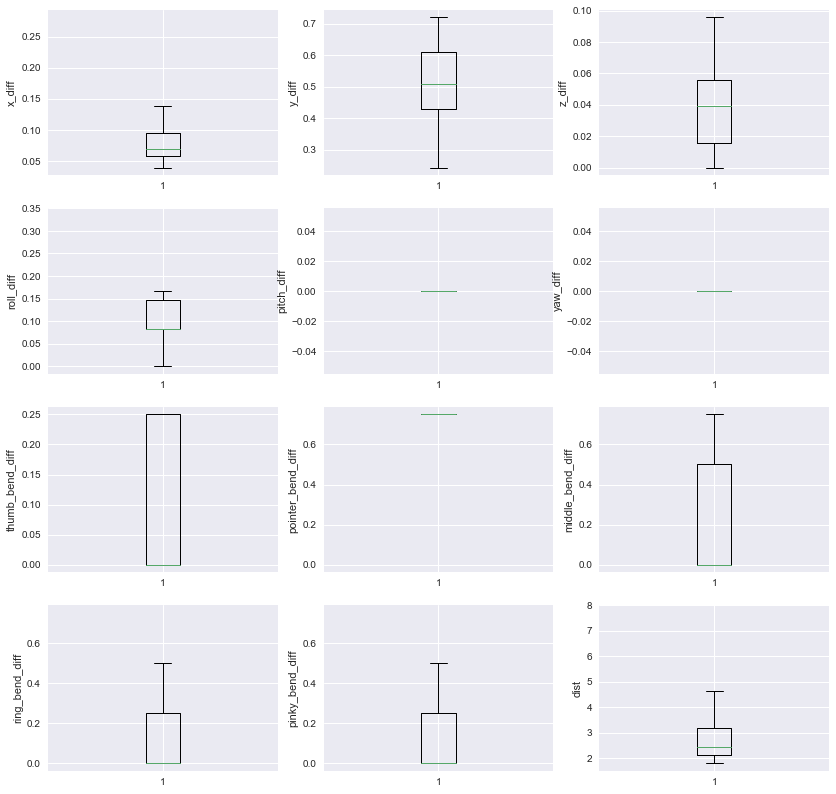

In [5]:
plot_diffs(what_features,'x_diff','y_diff','z_diff','roll_diff','pitch_diff','yaw_diff', \
           'thumb_bend_diff','pointer_bend_diff','middle_bend_diff','ring_bend_diff','pinky_bend_diff', 'dist')

## WHEN

In [6]:
when = read_all_files("when")
when_features = concat_diffs(when,'x','y','z',
  'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
when_features = concat_beg_end(when_features,when,'x','y','z', \
                           'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
when_features = add_dist(when_features, when)
when_features = add_num_frames(when_features, when)
when_features['is_what']=0
when_features.head(5)
#plot_diffs(when_features,'x_diff','y_diff','z_diff','roll_diff','pitch_diff','yaw_diff', \
#          'thumb_bend_diff','pointer_bend_diff','middle_bend_diff','ring_bend_diff','pinky_bend_diff', 'dist')

,signr_sess_test,x_25,x_75,x_diff,y_25,y_75,y_diff,z_25,z_75,z_diff,pitch_25,pitch_75,pitch_diff,roll_25,roll_75,roll_diff,yaw_25,yaw_75,yaw_diff,thumb_bend_25,thumb_bend_75,thumb_bend_diff,pointer_bend_25,pointer_bend_75,pointer_bend_diff,...,pointer_bend_middle_field,pointer_bend_last_first,pointer_bend_last_middle,pointer_bend_middle_first,middle_bend_first_field,middle_bend_last_field,middle_bend_middle_field,middle_bend_last_first,middle_bend_last_middle,middle_bend_middle_first,ring_bend_first_field,ring_bend_last_field,ring_bend_middle_field,ring_bend_last_first,ring_bend_last_middle,ring_bend_middle_first,pinky_bend_first_field,pinky_bend_last_field,pinky_bend_middle_field,pinky_bend_last_first,pinky_bend_last_middle,pinky_bend_middle_first,dist,num_frames,is_what
0,adam1-1,-0.326172,-0.007812,0.318360,0.029297,0.697265,0.667968,-0.007812,0.015625,0.023437,-1.0,-1.0,0.0,0.083333,0.250000,0.166667,-1.0,-1.0,0.0,0.0,0.00,0.00,0.0,0.75,0.75,...,0.00,0.0,0.75,-0.75,0.25,0.50,0.00,0.25,0.50,-0.25,0.50,0.75,0.00,0.25,0.75,-0.50,0.50,0.75,0.00,0.25,0.75,-0.50,2.029977,56.0,0
1,adam2-1,-0.197265,0.009765,0.207031,0.015625,0.761719,0.746094,0.000000,0.023438,0.023438,-1.0,-1.0,0.0,0.083333,0.333333,0.250000,-1.0,-1.0,0.0,0.5,0.50,0.00,0.0,0.75,0.75,...,0.00,0.0,0.75,-0.75,0.50,0.75,0.00,0.25,0.75,-0.50,0.50,0.75,0.00,0.25,0.75,-0.50,0.50,0.75,0.00,0.25,0.75,-0.50,2.649872,48.0,0
2,adam2-5,-0.464844,-0.031250,0.433594,0.000000,0.722656,0.722656,-0.007812,0.000000,0.007812,-1.0,-1.0,0.0,0.083333,0.333333,0.250000,-1.0,-1.0,0.0,0.5,0.50,0.00,0.0,0.75,0.75,...,0.00,0.0,0.75,-0.75,0.75,0.75,0.25,0.00,0.50,-0.50,0.75,0.75,0.00,0.00,0.75,-0.75,0.75,0.75,0.00,0.00,0.75,-0.75,2.641913,58.0,0
3,andrew1-0,-0.185547,0.015625,0.201172,0.015625,0.585938,0.570313,0.000000,0.070312,0.070312,-1.0,-1.0,0.0,0.000000,0.333333,0.333333,-1.0,-1.0,0.0,0.0,0.00,0.00,0.0,0.75,0.75,...,0.00,0.0,0.75,-0.75,0.75,0.75,0.00,0.00,0.75,-0.75,0.75,0.50,0.00,-0.25,0.50,-0.75,0.75,0.50,0.00,-0.25,0.50,-0.75,2.320228,98.0,0
4,andrew2-0,-0.162110,0.000000,0.162110,-0.039062,0.316406,0.355468,0.000000,0.007812,0.007812,-1.0,-1.0,0.0,0.083333,0.083333,0.000000,-1.0,-1.0,0.0,0.0,0.25,0.25,0.0,0.75,0.75,...,0.75,0.0,0.00,0.00,0.25,0.75,0.75,0.50,0.00,0.50,0.00,0.75,0.75,0.75,0.00,0.75,0.00,0.75,0.75,0.75,0.00,0.75,2.359726,124.0,0


## WHERE

In [7]:
where = read_all_files("where")
where_features = concat_diffs(where,'x','y','z',
  'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
where_features = concat_beg_end(where_features,where,'x','y','z', \
                           'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
where_features = add_dist(where_features, where)
where_features = add_num_frames(where_features, where)
where_features['is_what']=0
where_features.head(5)

,signr_sess_test,x_25,x_75,x_diff,y_25,y_75,y_diff,z_25,z_75,z_diff,pitch_25,pitch_75,pitch_diff,roll_25,roll_75,roll_diff,yaw_25,yaw_75,yaw_diff,thumb_bend_25,thumb_bend_75,thumb_bend_diff,pointer_bend_25,pointer_bend_75,pointer_bend_diff,...,pointer_bend_middle_field,pointer_bend_last_first,pointer_bend_last_middle,pointer_bend_middle_first,middle_bend_first_field,middle_bend_last_field,middle_bend_middle_field,middle_bend_last_first,middle_bend_last_middle,middle_bend_middle_first,ring_bend_first_field,ring_bend_last_field,ring_bend_middle_field,ring_bend_last_first,ring_bend_last_middle,ring_bend_middle_first,pinky_bend_first_field,pinky_bend_last_field,pinky_bend_middle_field,pinky_bend_last_first,pinky_bend_last_middle,pinky_bend_middle_first,dist,num_frames,is_what
0,adam1-1,-0.078125,-0.001953,0.076172,0.007812,0.140625,0.132813,-0.031250,0.0,0.031250,-1.0,-1.0,0.0,0.083333,0.333333,0.250000,-1.0,-1.0,0.0,0.0,0.0000,0.0000,0.0,0.75,0.75,...,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.00,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,1.402963,50.0,0
1,adam2-0,0.007812,0.031250,0.023438,-0.007812,0.093750,0.101562,-0.023438,0.0,0.023438,-1.0,-1.0,0.0,0.000000,0.333333,0.333333,-1.0,-1.0,0.0,0.5,0.5000,0.0000,0.0,0.75,0.75,...,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.00,0.75,-0.75,0.25,0.75,0.0,0.5,0.75,-0.25,0.25,0.75,0.0,0.5,0.75,-0.25,1.381627,46.0,0
2,adam2-3,-0.039062,0.021485,0.060547,0.023438,0.179688,0.156250,-0.037109,0.0,0.037109,-1.0,-1.0,0.0,0.020833,0.395834,0.375000,-1.0,-1.0,0.0,0.5,0.5000,0.0000,0.0,0.75,0.75,...,0.0,0.0,0.75,-0.75,0.50,0.75,0.0,0.25,0.75,-0.50,0.75,0.75,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,1.601010,50.0,0
3,andrew1-0,-0.062500,0.000000,0.062500,0.000000,0.046875,0.046875,-0.039062,0.0,0.039062,-1.0,-1.0,0.0,0.083333,0.416667,0.333334,-1.0,-1.0,0.0,0.0,0.0000,0.0000,0.0,0.75,0.75,...,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.00,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,2.406588,92.0,0
4,andrew2-0,-0.113281,0.007812,0.121093,0.000000,0.031250,0.031250,-0.062500,0.0,0.062500,-1.0,-1.0,0.0,0.000000,0.416667,0.416667,-1.0,-1.0,0.0,0.0,0.0625,0.0625,0.0,0.75,0.75,...,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.00,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,2.053828,84.0,0


In [8]:
len(what_features)

35

## WHICH

In [9]:
which = read_all_files("which")
which_features = concat_diffs(which,'x','y','z',
  'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
which_features = concat_beg_end(which_features,where,'x','y','z', \
                           'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
which_features = add_dist(which_features, which)
which_features = add_num_frames(which_features, which)
which_features['is_what']=0
which_features.head(5)


,signr_sess_test,x_25,x_75,x_diff,y_25,y_75,y_diff,z_25,z_75,z_diff,pitch_25,pitch_75,pitch_diff,roll_25,roll_75,roll_diff,yaw_25,yaw_75,yaw_diff,thumb_bend_25,thumb_bend_75,thumb_bend_diff,pointer_bend_25,pointer_bend_75,pointer_bend_diff,...,pointer_bend_middle_field,pointer_bend_last_first,pointer_bend_last_middle,pointer_bend_middle_first,middle_bend_first_field,middle_bend_last_field,middle_bend_middle_field,middle_bend_last_first,middle_bend_last_middle,middle_bend_middle_first,ring_bend_first_field,ring_bend_last_field,ring_bend_middle_field,ring_bend_last_first,ring_bend_last_middle,ring_bend_middle_first,pinky_bend_first_field,pinky_bend_last_field,pinky_bend_middle_field,pinky_bend_last_first,pinky_bend_last_middle,pinky_bend_middle_first,dist,num_frames,is_what
0,adam1-1,-0.101562,0.031250,0.132812,0.023438,0.265625,0.242187,-0.070312,0.007812,0.078124,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.00,0.00,0.0,0.75,0.7500,0.0000,...,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.00,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,1.539124,51.0,0
1,adam2-0,-0.222657,-0.085938,0.136719,0.054688,0.339844,0.285156,-0.062500,0.000000,0.062500,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.25,0.25,0.0,0.75,0.7500,0.0000,...,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.00,0.75,-0.75,0.25,0.75,0.0,0.5,0.75,-0.25,0.25,0.75,0.0,0.5,0.75,-0.25,1.763396,47.0,0
2,adam2-3,-0.050781,0.025391,0.076172,0.000000,0.361328,0.361328,-0.064453,0.000000,0.064453,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.25,0.25,0.0,0.25,0.5625,0.3125,...,0.0,0.0,0.75,-0.75,0.50,0.75,0.0,0.25,0.75,-0.50,0.75,0.75,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,1.770048,48.0,0
3,andrew1-0,-0.085938,0.000000,0.085938,0.000000,0.304688,0.304688,-0.023438,0.000000,0.023438,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.00,0.00,0.0,0.75,0.7500,0.0000,...,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.00,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,2.493143,121.0,0
4,andrew2-0,-0.039062,0.015625,0.054687,0.000000,0.281250,0.281250,0.000000,0.007812,0.007812,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.00,0.00,0.0,0.50,0.7500,0.2500,...,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.00,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,0.75,0.75,0.0,0.0,0.75,-0.75,1.510520,65.0,0


## WHO

In [10]:
who = read_all_files("who")
who_features = concat_diffs(who,'x','y','z',
  'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
who_features = concat_beg_end(who_features,who,'x','y','z', \
                           'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
who_features = add_dist(who_features, who)
who_features = add_num_frames(who_features, who)
who_features['is_what']=0
who_features.head(5)


,signr_sess_test,x_25,x_75,x_diff,y_25,y_75,y_diff,z_25,z_75,z_diff,pitch_25,pitch_75,pitch_diff,roll_25,roll_75,roll_diff,yaw_25,yaw_75,yaw_diff,thumb_bend_25,thumb_bend_75,thumb_bend_diff,pointer_bend_25,pointer_bend_75,pointer_bend_diff,...,pointer_bend_middle_field,pointer_bend_last_first,pointer_bend_last_middle,pointer_bend_middle_first,middle_bend_first_field,middle_bend_last_field,middle_bend_middle_field,middle_bend_last_first,middle_bend_last_middle,middle_bend_middle_first,ring_bend_first_field,ring_bend_last_field,ring_bend_middle_field,ring_bend_last_first,ring_bend_last_middle,ring_bend_middle_first,pinky_bend_first_field,pinky_bend_last_field,pinky_bend_middle_field,pinky_bend_last_first,pinky_bend_last_middle,pinky_bend_middle_first,dist,num_frames,is_what
0,adam2-0,-0.179688,-0.062500,0.117188,0.046875,0.609375,0.562500,-0.039062,-0.007812,0.031250,-1.0,-1.0,0.0,0.083333,0.333333,0.250000,-1.0,-1.0,0.0,0.5,0.5,0.0,0.0,0.75,0.75,...,0.0,0.25,0.75,-0.50,0.75,0.50,0.0,-0.25,0.50,-0.75,0.75,0.75,0.75,0.00,0.00,0.00,0.75,0.75,0.75,0.00,0.00,0.00,2.596516,50.0,0
1,adam2-1,-0.226562,-0.076172,0.150390,0.054688,0.628906,0.574218,-0.023438,0.000000,0.023438,-1.0,-1.0,0.0,0.083333,0.354166,0.270834,-1.0,-1.0,0.0,0.5,0.5,0.0,0.0,0.75,0.75,...,0.0,0.00,0.75,-0.75,0.50,0.50,0.5,0.00,0.00,0.00,0.75,0.50,0.75,-0.25,-0.25,0.00,0.75,0.50,0.75,-0.25,-0.25,0.00,2.531040,48.0,0
2,adam2-2,-0.181640,0.000000,0.181640,0.033203,0.638672,0.605469,-0.037109,0.000000,0.037109,-1.0,-1.0,0.0,0.083333,0.333333,0.250000,-1.0,-1.0,0.0,0.5,0.5,0.0,0.0,0.75,0.75,...,0.0,0.00,0.50,-0.50,0.50,0.25,0.5,-0.25,-0.25,0.00,0.50,0.50,0.75,0.00,-0.25,0.25,0.50,0.50,0.75,0.00,-0.25,0.25,3.111175,54.0,0
3,adam2-3,-0.158203,0.015625,0.173828,0.068359,0.658203,0.589844,-0.031250,0.000000,0.031250,-1.0,-1.0,0.0,0.083333,0.333333,0.250000,-1.0,-1.0,0.0,0.5,0.5,0.0,0.0,0.75,0.75,...,0.0,0.00,0.50,-0.50,0.25,0.25,0.5,0.00,-0.25,0.25,0.75,0.50,0.75,-0.25,-0.25,0.00,0.75,0.50,0.75,-0.25,-0.25,0.00,2.570996,48.0,0
4,andrew2-0,0.007812,0.062500,0.054688,-0.023438,-0.007812,0.015626,0.000000,0.000000,0.000000,-1.0,-1.0,0.0,0.000000,0.083333,0.083333,-1.0,-1.0,0.0,0.0,0.0,0.0,0.5,0.75,0.25,...,0.5,-0.75,-0.50,-0.25,0.25,0.00,0.0,-0.25,0.00,-0.25,0.75,0.00,0.75,-0.75,-0.75,0.00,0.75,0.00,0.75,-0.75,-0.75,0.00,3.776907,270.0,0


## WHY

In [11]:
why = read_all_files("why")
why_features = concat_diffs(why,'x','y','z',
  'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
why_features = concat_beg_end(why_features,why,'x','y','z', \
                           'pitch','roll','yaw','thumb_bend','pointer_bend','middle_bend','ring_bend','pinky_bend')
why_features = add_dist(why_features, why)
why_features = add_num_frames(why_features, why)
why_features['is_what']=0
why_features.head(5)


,signr_sess_test,x_25,x_75,x_diff,y_25,y_75,y_diff,z_25,z_75,z_diff,pitch_25,pitch_75,pitch_diff,roll_25,roll_75,roll_diff,yaw_25,yaw_75,yaw_diff,thumb_bend_25,thumb_bend_75,thumb_bend_diff,pointer_bend_25,pointer_bend_75,pointer_bend_diff,...,pointer_bend_middle_field,pointer_bend_last_first,pointer_bend_last_middle,pointer_bend_middle_first,middle_bend_first_field,middle_bend_last_field,middle_bend_middle_field,middle_bend_last_first,middle_bend_last_middle,middle_bend_middle_first,ring_bend_first_field,ring_bend_last_field,ring_bend_middle_field,ring_bend_last_first,ring_bend_last_middle,ring_bend_middle_first,pinky_bend_first_field,pinky_bend_last_field,pinky_bend_middle_field,pinky_bend_last_first,pinky_bend_last_middle,pinky_bend_middle_first,dist,num_frames,is_what
0,adam1-0,-0.353515,-0.023438,0.330077,0.054688,0.390625,0.335937,-0.039062,0.000000,0.039062,-1.0,-1.0,0.0,0.083333,0.083333,0.000000,-1.0,-1.0,0.0,0.0,0.00,0.00,0.0,0.75,0.75,...,0.0,0.0,0.75,-0.75,0.50,0.50,0.00,0.0,0.50,-0.50,0.50,0.50,0.50,0.0,0.00,0.00,0.50,0.50,0.50,0.0,0.00,0.00,1.668322,52.0,0
1,adam2-0,-0.382812,0.052735,0.435547,0.101562,0.462890,0.361328,0.007812,0.060547,0.052735,-1.0,-1.0,0.0,0.000000,0.229167,0.229167,-1.0,-1.0,0.0,0.5,0.50,0.00,0.0,0.75,0.75,...,0.0,0.5,0.50,0.00,0.25,0.25,0.00,0.0,0.25,-0.25,0.75,0.25,0.25,-0.5,0.00,-0.50,0.75,0.25,0.25,-0.5,0.00,-0.50,6.045561,50.0,0
2,adam2-3,-0.437499,0.000000,0.437499,0.085938,0.552735,0.466797,0.000000,0.037109,0.037109,-1.0,-1.0,0.0,0.000000,0.166667,0.166667,-1.0,-1.0,0.0,0.5,0.50,0.00,0.0,0.75,0.75,...,0.0,0.0,0.75,-0.75,0.25,0.25,0.00,0.0,0.25,-0.25,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,2.095945,42.0,0
3,andrew1-0,-0.171875,0.000000,0.171875,0.005859,0.250000,0.244141,0.000000,0.015625,0.015625,-1.0,-1.0,0.0,0.000000,0.083333,0.083333,-1.0,-1.0,0.0,0.0,0.25,0.25,0.0,0.75,0.75,...,0.0,0.0,0.75,-0.75,0.75,0.75,0.50,0.0,0.25,-0.25,0.00,0.00,0.75,0.0,-0.75,0.75,0.00,0.00,0.75,0.0,-0.75,0.75,2.432508,88.0,0
4,andrew2-0,-0.257812,0.000000,0.257812,0.000000,0.400391,0.400391,0.000000,0.007812,0.007812,-1.0,-1.0,0.0,0.000000,0.250000,0.250000,-1.0,-1.0,0.0,0.0,0.00,0.00,0.0,0.50,0.50,...,0.0,0.0,0.75,-0.75,0.50,0.50,0.25,0.0,0.25,-0.25,0.75,0.75,0.25,0.0,0.50,-0.50,0.75,0.75,0.25,0.0,0.50,-0.50,2.309182,88.0,0


# Can we distinguish between "What" and "Not What"?

In [12]:
   # start with just what and when.
df=pd.concat([what_features,when_features,where_features, which_features, who_features, why_features]).sort_index()
df=df[['x_diff','y_diff','z_diff','roll_diff','pitch_diff','yaw_diff', \
         'thumb_bend_diff','pointer_bend_diff','middle_bend_diff','ring_bend_diff','pinky_bend_diff', \
       'x_last_first', 'x_last_middle', 'x_middle_first', \
       'y_last_first', 'y_last_middle', 'y_middle_first', \
       'z_last_first', 'z_last_middle', 'z_middle_first', \
       'roll_last_first', 'roll_last_middle', 'roll_middle_first', \
       'pitch_last_first', 'pitch_last_middle', 'pitch_middle_first', \
       'yaw_last_first', 'yaw_last_middle', 'yaw_middle_first', \
       'thumb_bend_last_first', 'thumb_bend_last_middle', 'thumb_bend_middle_first', \
       'pointer_bend_last_first', 'pointer_bend_last_middle', 'pointer_bend_middle_first', \
       'middle_bend_last_first', 'middle_bend_last_middle', 'middle_bend_middle_first', \
       'ring_bend_last_first', 'ring_bend_last_middle', 'ring_bend_middle_first', \
       'pinky_bend_last_first', 'pinky_bend_last_middle', 'pinky_bend_middle_first', \
      'num_frames', 'dist', \
     'is_what']]
df.is_what.value_counts()





0    173
1     35
Name: is_what, dtype: int64

In [13]:
df.columns

Index([u'x_diff', u'y_diff', u'z_diff', u'roll_diff', u'pitch_diff',
       u'yaw_diff', u'thumb_bend_diff', u'pointer_bend_diff',
       u'middle_bend_diff', u'ring_bend_diff', u'pinky_bend_diff',
       u'x_last_first', u'x_last_middle', u'x_middle_first', u'y_last_first',
       u'y_last_middle', u'y_middle_first', u'z_last_first', u'z_last_middle',
       u'z_middle_first', u'roll_last_first', u'roll_last_middle',
       u'roll_middle_first', u'pitch_last_first', u'pitch_last_middle',
       u'pitch_middle_first', u'yaw_last_first', u'yaw_last_middle',
       u'yaw_middle_first', u'thumb_bend_last_first',
       u'thumb_bend_last_middle', u'thumb_bend_middle_first',
       u'pointer_bend_last_first', u'pointer_bend_last_middle',
       u'pointer_bend_middle_first', u'middle_bend_last_first',
       u'middle_bend_last_middle', u'middle_bend_middle_first',
       u'ring_bend_last_first', u'ring_bend_last_middle',
       u'ring_bend_middle_first', u'pinky_bend_last_first',
       u'pi

In [14]:
   # what appears 17% of the time
df.is_what.mean()

0.16826923076923078

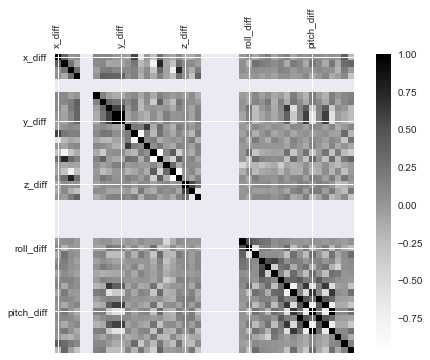

In [15]:
corr = df.corr()
list(corr.columns)
figure = plt.figure()
subplot = figure.add_subplot(1, 1, 1)
figure.colorbar(subplot.matshow(corr))
subplot.set_xticklabels([None] + list(corr.columns), rotation = 90)
subplot.set_yticklabels([None] + list(corr.columns))


In [16]:
    # get rid of pitch_diff, yaw_diff and their first/middle/last counterparts.
    # get rid of one of ring_* vs pinky_* because they are the same.
    #take y_diff  only.  remove y_last_middle and y_middle_first
    #take z_diff only.  remove z_last_middle and z_middle_first
    #take middle_bend_diff only.  remove middle_bend_last_middle, middle_bend_middle_first
    #take ring_bend_diff only.  remove ring_bend_last_middle, ring_bend_middle_first
    
df.corr()

,x_diff,y_diff,z_diff,roll_diff,pitch_diff,yaw_diff,thumb_bend_diff,pointer_bend_diff,middle_bend_diff,ring_bend_diff,pinky_bend_diff,x_last_first,x_last_middle,x_middle_first,y_last_first,y_last_middle,y_middle_first,z_last_first,z_last_middle,z_middle_first,roll_last_first,roll_last_middle,roll_middle_first,pitch_last_first,pitch_last_middle,pitch_middle_first,yaw_last_first,yaw_last_middle,yaw_middle_first,thumb_bend_last_first,thumb_bend_last_middle,thumb_bend_middle_first,pointer_bend_last_first,pointer_bend_last_middle,pointer_bend_middle_first,middle_bend_last_first,middle_bend_last_middle,middle_bend_middle_first,ring_bend_last_first,ring_bend_last_middle,ring_bend_middle_first,pinky_bend_last_first,pinky_bend_last_middle,pinky_bend_middle_first,num_frames,dist,is_what
x_diff,1.000000,0.390199,0.008443,0.062142,NaN,NaN,0.106152,0.089503,0.120754,0.006641,0.006641,-0.047551,0.566709,-0.586789,-0.002984,-0.285007,0.278281,-0.042552,-0.100891,0.097135,-0.124373,-0.126864,0.031225,NaN,NaN,NaN,NaN,NaN,NaN,-0.001082,0.094168,-0.103577,0.056551,0.156832,-0.089871,0.073355,0.141112,-0.089624,0.076617,0.005619,0.056216,0.076617,0.005619,0.056216,0.013009,0.409806,-0.214999
y_diff,0.390199,1.000000,0.239502,-0.120314,NaN,NaN,0.083648,0.104352,-0.102590,-0.074047,-0.074047,0.034443,0.221660,-0.209319,-0.077867,-0.773159,0.736807,-0.106396,-0.301179,0.293986,0.070269,0.090292,-0.039637,NaN,NaN,NaN,NaN,NaN,NaN,0.054053,-0.196359,0.264223,0.191222,0.134069,0.075622,0.132877,-0.118786,0.209350,0.104832,-0.119869,0.213871,0.104832,-0.119869,0.213871,-0.137069,0.303732,0.344000
z_diff,0.008443,0.239502,1.000000,0.288758,NaN,NaN,-0.054135,0.175403,0.203017,0.112880,0.112880,0.098117,0.140384,-0.103516,0.074151,-0.322693,0.335196,-0.072126,-0.746888,0.766396,0.025308,-0.141271,0.191080,NaN,NaN,NaN,NaN,NaN,NaN,0.063269,-0.008663,0.068364,0.040139,0.039260,0.005225,0.139649,0.111486,-0.014600,0.078929,0.034497,0.027088,0.078929,0.034497,0.027088,-0.184754,0.187689,-0.047753
roll_diff,0.062142,-0.120314,0.288758,1.000000,NaN,NaN,0.020191,0.395733,0.364739,0.345149,0.345149,0.052785,0.166505,-0.146988,0.103643,-0.124373,0.148670,-0.086661,-0.261968,0.256857,0.045841,-0.273004,0.366332,NaN,NaN,NaN,NaN,NaN,NaN,-0.023402,-0.032033,0.013095,-0.068685,-0.000573,-0.072737,0.041624,0.051490,-0.022481,-0.008143,0.111166,-0.125971,-0.008143,0.111166,-0.125971,-0.041650,0.093830,-0.302960
pitch_diff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yaw_diff,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
thumb_bend_diff,0.106152,0.083648,-0.054135,0.020191,NaN,NaN,1.000000,0.145331,-0.056232,-0.126780,-0.126780,0.021905,0.100738,-0.092749,0.096649,-0.118319,0.140928,0.046299,-0.027366,0.037614,-0.059916,0.066280,-0.135493,NaN,NaN,NaN,NaN,NaN,NaN,-0.022476,-0.104377,0.092756,-0.063473,0.037675,-0.103810,-0.030023,-0.197746,0.175662,-0.043838,-0.182845,0.160698,-0.043838,-0.182845,0.160698,0.001127,0.098905,0.147369
pointer_bend_diff,0.089503,0.104352,0.175403,0.395733,NaN,NaN,0.145331,1.000000,0.329946,0.236042,0.236042,0.087939,0.239726,-0.207079,0.070177,-0.363735,0.374350,-0.069393,-0.240673,0.237969,0.049791,0.054733,-0.017161,NaN,NaN,NaN,NaN,NaN,NaN,0.029662,-0.090404,0.126097,0.043739,0.205986,-0.150620,0.146018,-0.127327,0.226870,0.076581,-0.122666,0.193922,0.076581,-0.122666,0.193922,-0.085411,0.104365,0.185535
middle_bend_diff,0.120754,-0.102590,0.203017,0.364739,NaN,NaN,-0.056232,0.329946,1.000000,0.596819,0.596819,0.006352,0.223421,-0.221781,-0.001677,0.024507,-0.024430,0.011465,-0.134378,0.142649,0.029114,-0.084873,0.128070,NaN,NaN,NaN,NaN,NaN,NaN,0.003873,0.228949,-0.245770,-0.010751,0.109934,-0.116764,0.099224,0.637036,-0.564167,0.133886,0.417511,-0.339492,0.133886,

In [17]:
df.isnull().sum().sum()

0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b248910>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11b132650>, ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11c36f790>, ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11d486bd0>, ...,
       ..., 
        <matplotlib.axes._subplots.AxesSubplot object at 0x13cede590>, ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13df0bc90>, ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13f017790>, ...,
        <matplotlib.axes._subplots.AxesSubplot object at 0x13ffb7050>]], dtype=object)

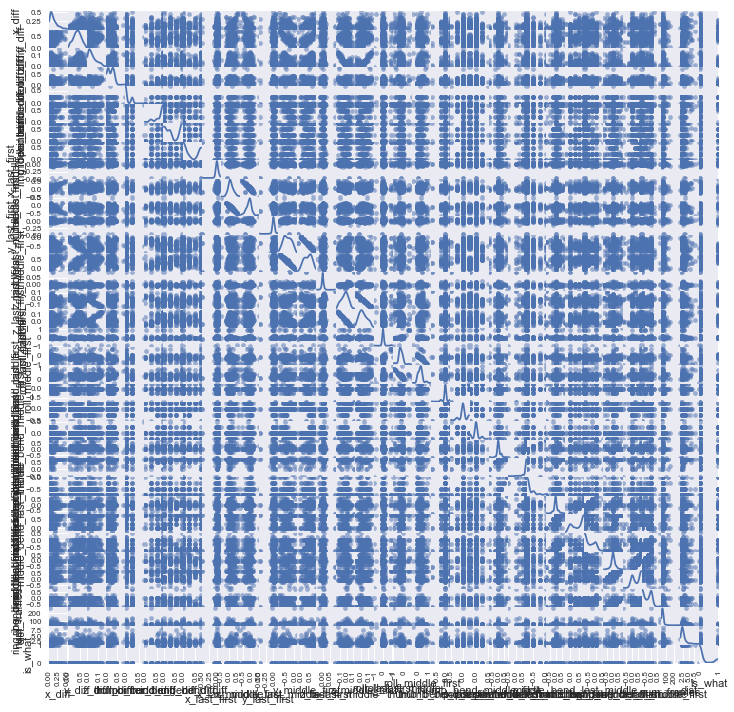

In [18]:
    # took out pitch_diff and yaw_diff because always 0.  took out pinky_bend_diff because same as ring_bend_diff
pd.tools.plotting.scatter_matrix(
    df[ ['x_diff','y_diff','z_diff', 'roll_diff',\
         #'pitch_diff','yaw_diff', \
           'thumb_bend_diff','pointer_bend_diff','middle_bend_diff','ring_bend_diff', \
           #,'pinky_bend_diff', \
       'x_last_first', 'x_last_middle', 'x_middle_first', \
       'y_last_first', 'y_last_middle', 'y_middle_first', \
       'z_last_first', 'z_last_middle', 'z_middle_first', \
       'roll_last_first', 'roll_last_middle', 'roll_middle_first', \
       'thumb_bend_last_first', 'thumb_bend_last_middle', 'thumb_bend_middle_first', \
       'pointer_bend_last_first', 'pointer_bend_last_middle', 'pointer_bend_middle_first', \
       'middle_bend_last_first', 'middle_bend_last_middle', 'middle_bend_middle_first', \
       'ring_bend_last_first', 'ring_bend_last_middle', 'ring_bend_middle_first', \
         'num_frames', 'dist', \
         'is_what'] ],
    diagonal = 'kde', s = 75, figsize = (12, 12))

## Stratify Data Sample--up sampling

In [19]:
ns = df.is_what.value_counts()
ns[0]-ns.min()

138

In [20]:
   # re-sample another 138 out of the is_what=1 group
is_what1 = df[df.is_what==1].sample(n=ns[0], replace=True)

In [21]:
df = pd.concat(  [is_what1, df[df.is_what==0]  ]  ).sort_index()
df.head()

,x_diff,y_diff,z_diff,roll_diff,pitch_diff,yaw_diff,thumb_bend_diff,pointer_bend_diff,middle_bend_diff,ring_bend_diff,pinky_bend_diff,x_last_first,x_last_middle,x_middle_first,y_last_first,y_last_middle,y_middle_first,z_last_first,z_last_middle,z_middle_first,roll_last_first,roll_last_middle,roll_middle_first,pitch_last_first,pitch_last_middle,pitch_middle_first,yaw_last_first,yaw_last_middle,yaw_middle_first,thumb_bend_last_first,thumb_bend_last_middle,thumb_bend_middle_first,pointer_bend_last_first,pointer_bend_last_middle,pointer_bend_middle_first,middle_bend_last_first,middle_bend_last_middle,middle_bend_middle_first,ring_bend_last_first,ring_bend_last_middle,ring_bend_middle_first,pinky_bend_last_first,pinky_bend_last_middle,pinky_bend_middle_first,num_frames,dist,is_what
0,0.132812,0.242187,0.078124,0.000000,0.0,0.0,0.0,0.00,0.00,0.00,0.00,-0.039062,0.078126,-0.117188,0.023438,-0.117187,0.140625,0.000000,0.039062,-0.039062,0.000000,-0.333334,0.333334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.75,-0.75,0.00,0.75,-0.75,0.00,0.75,-0.75,0.00,0.75,-0.75,51.0,1.539124,0
0,0.117188,0.562500,0.031250,0.250000,0.0,0.0,0.0,0.75,0.50,0.00,0.00,-0.054688,0.273437,-0.328125,0.031250,-0.625000,0.656250,0.000000,0.054688,-0.054688,0.083333,-0.250000,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.75,-0.50,-0.25,0.50,-0.75,0.00,0.00,0.00,0.00,0.00,0.00,50.0,2.596516,0
0,0.101562,0.464844,0.054688,0.083333,0.0,0.0,0.0,0.75,0.00,0.00,0.00,-0.023438,0.117187,-0.140625,0.000000,-0.468750,0.468750,0.000000,0.070312,-0.070312,0.000000,-0.083333,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.75,-0.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,54.0,3.926068,1
0,0.076172,0.132813,0.031250,0.250000,0.0,0.0,0.0,0.75,0.75,0.75,0.75,-0.039062,0.078126,-0.117188,0.023438,-0.117187,0.140625,0.000000,0.039062,-0.039062,0.000000,-0.333334,0.333334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.75,-0.75,0.00,0.75,-0.75,0.00,0.75,-0.75,0.00,0.75,-0.75,50.0,1.402963,0
0,0.318360,0.667968,0.023437,0.166667,0.0,0.0,0.0,0.75,0.75,0.75,0.75,0.000000,0.390625,-0.390625,0.015626,-0.679687,0.695313,-0.007812,-0.031250,0.023438,-0.083333,-0.333333,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.75,-0.75,0.25,0.50,-0.25,0.25,0.75,-0.50,0.25,0.75,-0.50,56.0,2.029977,0


In [22]:
df.is_what.value_counts()

1    173
0    173
Name: is_what, dtype: int64

In [23]:
df.groupby('is_what').mean()

,x_diff,y_diff,z_diff,roll_diff,pitch_diff,yaw_diff,thumb_bend_diff,pointer_bend_diff,middle_bend_diff,ring_bend_diff,pinky_bend_diff,x_last_first,x_last_middle,x_middle_first,y_last_first,y_last_middle,y_middle_first,z_last_first,z_last_middle,z_middle_first,roll_last_first,roll_last_middle,roll_middle_first,pitch_last_first,pitch_last_middle,pitch_middle_first,yaw_last_first,yaw_last_middle,yaw_middle_first,thumb_bend_last_first,thumb_bend_last_middle,thumb_bend_middle_first,pointer_bend_last_first,pointer_bend_last_middle,pointer_bend_middle_first,middle_bend_last_first,middle_bend_last_middle,middle_bend_middle_first,ring_bend_last_first,ring_bend_last_middle,ring_bend_middle_first,pinky_bend_last_first,pinky_bend_last_middle,pinky_bend_middle_first,num_frames,dist
is_what,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.147241,0.352217,0.045249,0.215559,0.0,0.0,0.061055,0.594292,0.407876,0.368136,0.368136,0.003793,0.149025,-0.145231,0.012058,-0.340453,0.352511,0.001445,-0.027637,0.029082,0.029865,-0.291908,0.321773,0.0,0.0,0.0,0.0,0.0,0.0,-0.008671,0.033237,-0.041908,0.036127,0.684971,-0.648844,0.018786,0.507225,-0.488439,0.028902,0.437861,-0.408960,0.028902,0.437861,-0.408960,62.271676,2.484729
1,0.086615,0.508637,0.042698,0.104528,0.0,0.0,0.083815,0.703396,0.153179,0.154263,0.154263,0.021767,0.054913,-0.033147,-0.004651,-0.583183,0.578531,0.000948,-0.029263,0.030211,0.012042,-0.131985,0.144027,0.0,0.0,0.0,0.0,0.0,0.0,0.018786,-0.040462,0.059249,0.092486,0.712428,-0.619942,0.005780,0.187861,-0.182081,-0.028902,0.095376,-0.124277,-0.028902,0.095376,-0.124277,54.913295,2.785567


# FULL FEATURE SET

## Logistic Regression with Grid Search

In [24]:
X = df[['x_diff','y_diff','z_diff', 'roll_diff',\
     #    'pitch_diff','yaw_diff', \
           'thumb_bend_diff','pointer_bend_diff','middle_bend_diff','ring_bend_diff', \
           'pinky_bend_diff', \
       'x_last_first', 'x_last_middle', 'x_middle_first', \
       'y_last_first', \
         'y_last_middle', 'y_middle_first', \
       'z_last_first', \
         'z_last_middle', 'z_middle_first', \
       'roll_last_first', 'roll_last_middle', 'roll_middle_first', \
       'thumb_bend_last_first', 'thumb_bend_last_middle', 'thumb_bend_middle_first', \
       'pointer_bend_last_first', 'pointer_bend_last_middle', 'pointer_bend_middle_first', \
       'middle_bend_last_first', \
        'middle_bend_last_middle', 'middle_bend_middle_first', \
       'ring_bend_last_first', \
        'ring_bend_last_middle', 'ring_bend_middle_first', \
       'num_frames','dist' ]]
Y = df['is_what']

   # normalization and grid search
scaler = preprocessing.MinMaxScaler().fit(X)

X = pd.DataFrame(scaler.transform(X), columns = X.columns)

gs = model_selection.GridSearchCV(
    estimator = linear_model.LogisticRegression(),
    param_grid = {'C': np.logspace(-10, 10, 21), 'penalty': ['l1']},
    cv = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 3)
)

gs.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=3, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1'], 'C': array([  1.00000e-10,   1.00000e-09,   1.00000e-08,   1.00000e-07,
         1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [25]:
gs.best_params_

{'C': 1000.0, 'penalty': 'l1'}

In [26]:
gs.best_estimator_

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [27]:
model = gs.best_estimator_.fit(X, Y)
print model.intercept_
print zip(X.columns, model.coef_[0])

[ 3.74656017]
[('x_diff', -61.581076768437391), ('y_diff', 28.794781588333365), ('z_diff', -25.730268660959009), ('roll_diff', -72.028605995479197), ('thumb_bend_diff', 4.2430365526355498), ('pointer_bend_diff', 20.534393042399529), ('middle_bend_diff', -8.42915888239264), ('ring_bend_diff', -3.1144983979850713), ('pinky_bend_diff', -2.5966622497755205), ('x_last_first', 7.9559739181851947), ('x_last_middle', 0.0), ('x_middle_first', 19.087293814776022), ('y_last_first', -8.0208593133094954), ('y_last_middle', -44.234713449032427), ('y_middle_first', 12.035858277122362), ('z_last_first', 0.0), ('z_last_middle', 0.0), ('z_middle_first', 12.64230630060152), ('roll_last_first', -13.202996398154491), ('roll_last_middle', 2.0266758254982591), ('roll_middle_first', -31.35178754321441), ('thumb_bend_last_first', 1.8267468714871249), ('thumb_bend_last_middle', 10.398598116263576), ('thumb_bend_middle_first', -4.7711285038860609), ('pointer_bend_last_first', 0.0), ('pointer_bend_last_middle', 2

In [28]:
from sklearn import model_selection
   # 0.83095238095238089 if take all variables
model_selection.cross_val_score(model, X , Y, cv= 5).mean()

0.90184873949579836

In [29]:
c_hat = model.predict(X)

pd.crosstab(c_hat,
    Y,
    rownames = ['Hypothesized Class'],
    colnames = ['True Class']) 

True Class,0,1
Hypothesized Class,,
0,173,0
1,0,173


## Random Forest with Grid Search

In [30]:
from sklearn.model_selection import GridSearchCV

# build a classifier
clf = ensemble.RandomForestClassifier(n_estimators=20)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 4, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True],
              "criterion": ["gini", "entropy"],
              "oob_score": [True]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, \
                              cv = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 3))
grid_search.fit(X, Y)

/Users/seanmcghee/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/seanmcghee/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


GridSearchCV(cv=KFold(n_splits=5, random_state=3, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'oob_score': [True], 'bootstrap': [True], 'min_samples_leaf': [1, 3, 10], 'min_samples_split': [2, 4, 10], 'criterion': ['gini', 'entropy'], 'max_features': [1, 3, 10], 'max_depth': [3, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [31]:
grid_search.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'oob_score': True}

In [32]:
model = grid_search.best_estimator_.fit(X, Y)
model.oob_score_

0.98843930635838151

In [33]:
model_selection.cross_val_score(model, X , Y, cv= 5).mean()

0.74277310924369755

In [34]:
c_hat = model.predict(X)

pd.crosstab(c_hat,
    Y,
    rownames = ['Hypothesized Class'],
    colnames = ['True Class']) 

True Class,0,1
Hypothesized Class,,
0,173,1
1,0,172


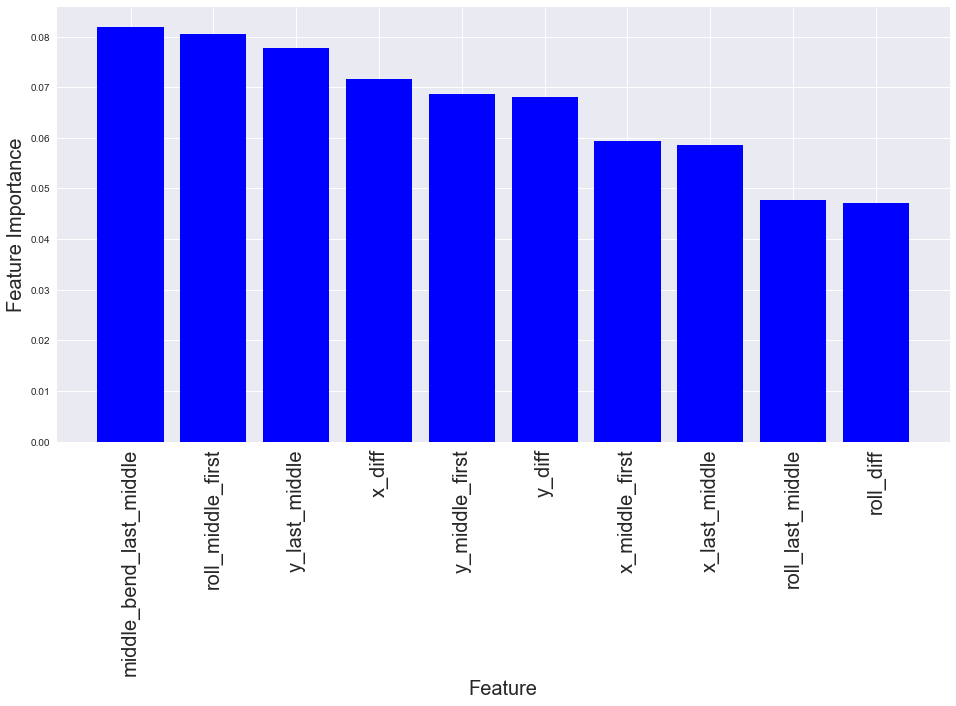

In [35]:
feature_importances = sorted(zip(model.feature_importances_, X.columns.values), reverse = True)   
feature_importances = feature_importances[:10]

plt.figure(figsize = (16, 8))

plt.bar(
    range(len(feature_importances)),
    [feature_importance[0] for feature_importance in feature_importances], color='b'
)

plt.xticks(
    range(len(feature_importances)),
    [feature_importance[1] for feature_importance in feature_importances],
    rotation = 90,
    fontsize=20
)

plt.xlabel('Feature',fontsize=20)
plt.ylabel('Feature Importance',fontsize=20)

## Findings:  Logistic Regression performs well for this specific set of two words:  What vs Which.  Important features ends up varying greatly by choice of two words to compare.

# LIMITED FEATURE SET

## Logistic Regression with Grid Search

In [36]:
    # get rid of pitch_diff, yaw_diff and their first/middle/last counterparts.
    # get rid of one of ring_* vs pinky_* because they are the same.
    #take y_diff  only.  remove y_last_middle and y_middle_first
    #take z_diff only.  remove z_last_middle and z_middle_first
    #take middle_bend_diff only.  remove middle_bend_last_middle, middle_bend_middle_first
    #take ring_bend_diff only.  remove ring_bend_last_middle, ring_bend_middle_first


X = df[['x_diff','y_diff','z_diff', 'roll_diff',\
     #    'pitch_diff','yaw_diff', \
           'thumb_bend_diff','pointer_bend_diff','middle_bend_diff','ring_bend_diff', \
           'pinky_bend_diff', \
       'x_last_first', 'x_last_middle', 'x_middle_first', \
       'y_last_first', \
         #'y_last_middle', 'y_middle_first', \
       'z_last_first', \
         #'z_last_middle', 'z_middle_first', \
       'roll_last_first', 'roll_last_middle', 'roll_middle_first', \
       'thumb_bend_last_first', 'thumb_bend_last_middle', 'thumb_bend_middle_first', \
       'pointer_bend_last_first', 'pointer_bend_last_middle', 'pointer_bend_middle_first', \
       'middle_bend_last_first', \
        #'middle_bend_last_middle', 'middle_bend_middle_first', \
       'ring_bend_last_first', \
       # 'ring_bend_last_middle', 'ring_bend_middle_first', \
       'num_frames','dist' ]]
Y = df['is_what']

   # normalization and grid search
scaler = preprocessing.MinMaxScaler().fit(X)

X = pd.DataFrame(scaler.transform(X), columns = X.columns)

gs = model_selection.GridSearchCV(
    estimator = linear_model.LogisticRegression(),
    param_grid = {'C': np.logspace(-10, 10, 21), 'penalty': ['l1']},
    cv = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 3)
)

gs.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=3, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1'], 'C': array([  1.00000e-10,   1.00000e-09,   1.00000e-08,   1.00000e-07,
         1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [37]:
gs.best_params_

{'C': 1000.0, 'penalty': 'l1'}

In [38]:
gs.best_estimator_

LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [39]:
model = gs.best_estimator_.fit(X, Y)
print model.intercept_
print zip(X.columns, model.coef_[0])

[-10.03389825]
[('x_diff', -45.854120810058738), ('y_diff', 80.296783390965331), ('z_diff', -9.6812535084981928), ('roll_diff', -98.159965025250955), ('thumb_bend_diff', 6.3074892081784038), ('pointer_bend_diff', 47.045207648243746), ('middle_bend_diff', -11.795299804287266), ('ring_bend_diff', -6.6767534348021078), ('pinky_bend_diff', -4.2378110518782393), ('x_last_first', 22.267732629692283), ('x_last_middle', -20.747752674534382), ('x_middle_first', 27.004896421386455), ('y_last_first', -38.692946224922252), ('z_last_first', 0.0), ('roll_last_first', -1.4138089117367865), ('roll_last_middle', 0.0), ('roll_middle_first', -47.920378774353139), ('thumb_bend_last_first', -6.7641313579643683), ('thumb_bend_last_middle', -0.15218561284956816), ('thumb_bend_middle_first', -2.9425673401464465), ('pointer_bend_last_first', 0.0), ('pointer_bend_last_middle', 0.0), ('pointer_bend_middle_first', 6.9252226972830844), ('middle_bend_last_first', 0.0), ('ring_bend_last_first', -30.136367870768549),

In [40]:
from sklearn import model_selection
   # 0.83095238095238089 if take all variables
model_selection.cross_val_score(model, X , Y, cv= 5).mean()

0.91050420168067225

In [41]:
c_hat = model.predict(X)

pd.crosstab(c_hat,
    Y,
    rownames = ['Hypothesized Class'],
    colnames = ['True Class']) 

True Class,0,1
Hypothesized Class,,
0,173,0
1,0,173


## Random Forest with Grid Search

In [42]:
from sklearn.model_selection import GridSearchCV

# build a classifier
clf = ensemble.RandomForestClassifier(n_estimators=20)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 4, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True],
              "criterion": ["gini", "entropy"],
              "oob_score": [True]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, \
                              cv = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 3))
grid_search.fit(X, Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=3, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'oob_score': [True], 'bootstrap': [True], 'min_samples_leaf': [1, 3, 10], 'min_samples_split': [2, 4, 10], 'criterion': ['gini', 'entropy'], 'max_features': [1, 3, 10], 'max_depth': [3, None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [43]:
grid_search.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'oob_score': True}

In [44]:
model = grid_search.best_estimator_.fit(X, Y)
model.oob_score_

0.97687861271676302

In [45]:
model_selection.cross_val_score(model, X , Y, cv= 5).mean()

0.76873949579831935

In [46]:
c_hat = model.predict(X)

pd.crosstab(c_hat,
    Y,
    rownames = ['Hypothesized Class'],
    colnames = ['True Class']) 

True Class,0,1
Hypothesized Class,,
0,173,0
1,0,173


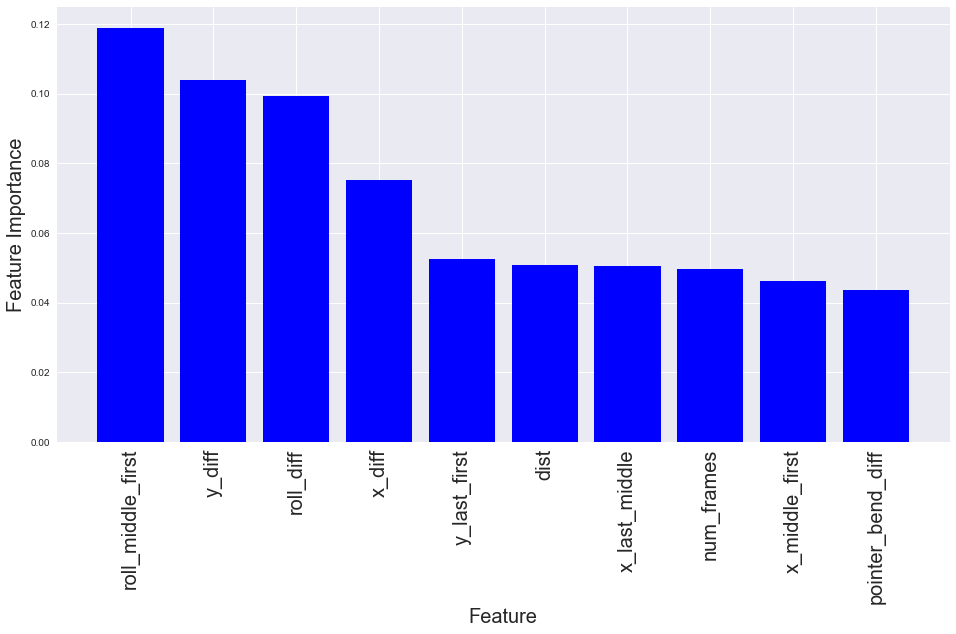

In [47]:
feature_importances = sorted(zip(model.feature_importances_, X.columns.values), reverse = True)   
feature_importances = feature_importances[:10]

plt.figure(figsize = (16, 8))

plt.bar(
    range(len(feature_importances)),
    [feature_importance[0] for feature_importance in feature_importances], color='b'
)

plt.xticks(
    range(len(feature_importances)),
    [feature_importance[1] for feature_importance in feature_importances],
    rotation = 90,
    fontsize=20
)

plt.xlabel('Feature',fontsize=20)
plt.ylabel('Feature Importance',fontsize=20)

## Findings:  Logistic Regression performs well for this specific set of two words:  What vs Which.  Important features ends up varying greatly by choice of two words to compare.